# **Patterns of Common Bird Observations in U.S. Metropolitan Areas**
**Full Version - GEOG 7940 Final Project - by Benjamin Tjepkes**

<div class="alert alert-block alert-danger">
<b>Caution:</b> This notebook is the full version to process >5M bird observation records for multiple U.S. cities and likely takes ~1 hour to run. Please see the abridged version of this notebook <code>FinalProject_Abridged_Tjepkes.ipynb</code> for a reproducible copy that runs more quickly to produce a map for a single city.
</div>

<hr>

**Objective:**

In this project, we are generating a series of maps that summarize bird observation patterns in the top metropolitan areas across the United States in 2021 and 2022. This workflow will utilize citizen science data from Project FeederWatch to understand the spatial patterns (e.g., spatial clustering, standard deviational ellipse) of the most-observed bird species during the project timeframe in U.S. metro areas with populations higher than 2-million people.

**Outline:**

1. [Introduction](#Introduction)
    - *Project FeederWatch*
    - *Data Sources*
1. [Setup & Configuration](#Setup-&-Configuration)
    - *Import Modules & Set Environmental Settings*
    - *Loading & Filtering U.S. Urban Areas*
    - *Loading & Filtering Bird Observation Data*
1. [Geoprocessing](#Geoprocessing)
    - *Reprojection & Feature Layers*
    - *Cluster & Outlier Detection*
    - *Standard Deviational Ellipse Development*
1. [Map Generation](#Map-Generation)
    - *Mapping Folder & Layer Configuration*
    - *Iterative Map Production*
1. [Appendix](#Appendix)

<hr>

## Introduction

### Project FeederWatch

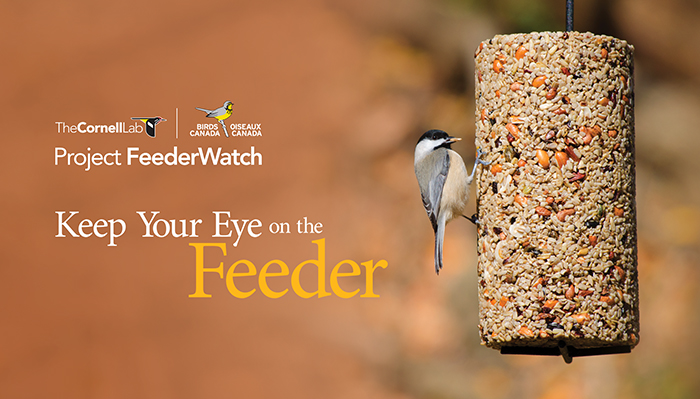

**Project FeederWatch** (PFW) is a citizen science program that engages bird enthusiasts of all skill levels in monitoring and documenting bird populations across North America. Launched by the Cornell Lab of Ornithology and Bird Studies Canada, this initiative encourages participants to set up bird feeders in their yards or local green spaces and regularly observe and record the species and numbers of birds that visit. These observations provide valuable data for scientists studying bird migration patterns, population trends, and the impact of environmental changes on bird populations. By fostering a sense of community among birdwatchers and contributing to scientific research, Project FeederWatch empowers individuals to play an active role in bird conservation efforts.

More information on PFW can be found here: [https://feederwatch.org/](https://feederwatch.org/).

### Data Sources

This workflow relies on two primary data sources to successfully complete this workflow:

**(1) 2020 U.S. Census Urban Areas**

To represent urban spaces for our exploration, we will use the 2020 U.S. Census designated urban boundaries. The definition used by the Census is *"an urban area will comprise a densely settled core of census blocks that meet minimum housing unit density and/or population density requirements"*. The U.S. Census and Esri maintain an ArcGIS Feature Service for this layer, which can be queried at: [USA Census Urban Areas](https://services.arcgis.com/P3ePLMYs2RVChkJx/ArcGIS/rest/services/USA_Census_Urban_Areas/FeatureServer/0). This is subset later on in this notebook.

**(2) FeederWatch Bird Observation Data**

To represent bird species occurence for our exploration, we will use the 2021-2023 dataset from Project FeederWatch. The Cornell Lab of Ornithology maintains raw data downloads available in .csv format at [https://feederwatch.org/explore/raw-dataset-requests/](https://feederwatch.org/explore/raw-dataset-requests/). Data for this project were downloaded directly from the "checklist data 2021-2023" link under RAW DATA ACCESS. These will be subset later on in this notebook.

## Setup & Configuration

<div class="alert alert-block alert-info">
<b>Goal:</b> This first section helps us lay the foundation for the workflow in this notebook, including establishing folder connections, loading in required packages, setting environmental settings through ArcGIS, and loading and filtering our project data from their respective sources.
</div>

### Import Modules & Set Environmental Settings

**// Import all required modules for this workflow.**
- Import all the required Python modules: `sys`, `os`, `arcpy`, `arcpy.env`, `arcpy.sa`, `csv`, `datetime`, `pandas`, and `arcgis.features`.
- These should all be available through the default Python environment shipped with ArcGIS Pro.
- Other needed modules are loaded within the script.

In [1]:
#import the sys module
import sys

#import the os module
import os

#import the arcpy module
import arcpy

#import the arcpy.env module
from arcpy import env

# import the arcpy.sa module
from arcpy import sa

#import the csv module
import csv

#import the datetime module
import datetime

# import pandas
import pandas as pd

# import GeoAccessor, GeoSeriesAccessor from arcgis.features module
from arcgis.features import GeoAccessor, GeoSeriesAccessor

**// Set base directory for the project.**
- Set the working directory using the `os.getcwd()` command.

In [2]:
#get path to the lab
BaseDirectory = os.getcwd()

if not os.path.exists(BaseDirectory):
    print ("File path is invalid")
else:
    print("Input working directory exists!")
    print()
    print('BaseDirectory = ',BaseDirectory)

Input working directory exists!

BaseDirectory =  D:\GIS2\FinalProject_Full


**// Uncompress the project data and template file.**
- Ensure that the project data folder 'projectData_full.zip' and project template folder 'projectTemplate_full.zip' are located in the BaseDirectory.
- Using the `os`, `shutil`, and `zipfile` modules, unzip the project template folder and the project data folder.

In [3]:
## Preparing data.
import os, shutil, zipfile

datadir = os.path.join(BaseDirectory,'projectData_full.zip')
with zipfile.ZipFile(datadir,'r') as zip_ref:
    zip_ref.extractall(BaseDirectory)    
    print('Data has been unzipped...no need to run this code block again')
    
datadir = os.path.join(BaseDirectory,'projectTemplate_full.zip')
with zipfile.ZipFile(datadir,'r') as zip_ref:
    zip_ref.extractall(BaseDirectory)    
    print('Data has been unzipped...no need to run this code block again')

Data has been unzipped...no need to run this code block again
Data has been unzipped...no need to run this code block again


**// Configure default workspaces and environmental settings.**
- Define a working geodatabase to store the output feature classes in this workflow.
- Replace this working GDB if one existing in the base directory.
- Set the env.workspace to this GDB and allow for the overwriting in this space.
- Define a default scatchWorkspace and outputCoordinateSystem.

In [4]:
## Configure path to project geodatabase
inputGDB = "FinalProject.gdb"
inputGDBpath = os.path.join(BaseDirectory, inputGDB)

## Verify that the input gdb exists
if os.path.exists(inputGDB):
    print('The geodatabase',inputGDB,'exists, but will be replaced.')
    arcpy.management.Delete(in_data = inputGDB)
    arcpy.management.CreateFileGDB(out_folder_path = BaseDirectory,
                                   out_name = inputGDB)
else:
    print('The geodatabase',inputGDB,'DOES NOT exist and will be created.')
    arcpy.management.CreateFileGDB(out_folder_path = BaseDirectory,
                                   out_name = inputGDB)

## Set the workspace to your `Project_Template.gdb`.
arcpy.env.workspace = inputGDBpath
print('The current workspace is set to:', env.workspace)

## Configure the environment to permit overwriting of data
arcpy.env.overwriteOutput = True

## Set the scratch workspace to be a gdb named ScratchOutput.gdb in the `Project_Template_Folder` folder.
arcpy.env.scratchWorkspace = os.path.join(BaseDirectory,"ScratchOutput.gdb")

## Set default output CRS
arcpy.env.outputCoordinateSystem = arcpy.SpatialReference(102039) #NAD 1983 USGS Contiguous USA Albers

The geodatabase FinalProject.gdb DOES NOT exist and will be created.
The current workspace is set to: D:\GIS2\FinalProject_Full\FinalProject.gdb


**// Check to make sure the geodatabase is empty.**
- Iterate over the feature classes in the workspace to ensure it is fresh.
- Hint: `arcpy.ListFeatureClasses()`

In [5]:
# list feature classes in the workspace
FCList = arcpy.ListFeatureClasses()
print(FCList)

[]


### Loading & Filtering U.S. Urban Areas

**// Bring in the U.S. Census Urban Areas feature service layer as a feature layer.**
- Define a name and URL for the urban areas feature.
- Load in this feature as an in-memory feature layer.

In [6]:
# define a layer name for the urban areas
layer_name = "Urban Areas 2020"

# define the url for the urban area feature service
layer_url = "https://services.arcgis.com/P3ePLMYs2RVChkJx/ArcGIS/rest/services/USA_Census_Urban_Areas/FeatureServer/0"

# create a feature layer for the urban areas
urbanAreasFL = arcpy.management.MakeFeatureLayer(layer_url, 
                                                 layer_name)
print("MakeFeatureLayer")
print(arcpy.GetMessages())
print(urbanAreasFL, "was created.")

MakeFeatureLayer
Start Time: Tuesday, May 7, 2024 22:35:42
Succeeded at Tuesday, May 7, 2024 22:35:42 (Elapsed Time: 0.03 seconds)
Urban Areas 2020 was created.


**// List all the fields in the urban areas layer.**
- Iterate over the fields in our urban areas feature layer to get the field names.
- This will help us develop a where clause in the next step.

In [7]:
for i in arcpy.ListFields(urbanAreasFL):
    print(i.name)

OBJECTID
UA_CODE
NAME
POPULATION
POP_DENSITY
HOUSING
AREA_SQMI
Shape__Area
Shape__Length
Shape


**// Specify a where clause to select cities over 2M population, then select and copy this to a new feature class.**
- Using the SQL notation for ArcGIS, specify a where clause for only features will >2M population.
- Select by attribute using this where clause, then copy features to a new feature class.

In [8]:
# specify where clause
whereClause = "POPULATION > 2000000 And NAME <> 'San Juan, PR'"

# select using the where clause
arcpy.management.SelectLayerByAttribute(in_layer_or_view = urbanAreasFL,
                                        selection_type = "NEW_SELECTION",
                                        where_clause = whereClause,
                                        invert_where_clause = "NON_INVERT")

print("SelectLayerByAttribute")
print(arcpy.GetMessages())

# specify name for new urban areas layer
urbanAreasTopFC = "UrbanAreas"

# copy the urban areas using the 
arcpy.management.CopyFeatures(in_features = urbanAreasFL,
                              out_feature_class = urbanAreasTopFC)
print("CopyFeatures")
print(arcpy.GetMessages())

SelectLayerByAttribute
Start Time: Tuesday, May 7, 2024 22:35:42
Succeeded at Tuesday, May 7, 2024 22:35:43 (Elapsed Time: 0.38 seconds)
CopyFeatures
Start Time: Tuesday, May 7, 2024 22:35:43
Succeeded at Tuesday, May 7, 2024 22:35:47 (Elapsed Time: 4.65 seconds)


**// Create a spatially-enabled dataframe to preview features.**
- Using pandas, create a spatially-enabled df to view the attributes of our new feature class.
- Use the `.tolist()` method to convert the NAME field to a list of names.

In [9]:
# create a Spatially Enabled DataFrame object
sdf = pd.DataFrame.spatial.from_featureclass(urbanAreasTopFC)

# pull values from the NAME field and create a list
topCitieslist = sdf["NAME"].tolist()

# view the SDF object
print("These urban areas will each have their own map created:")
sdf

These urban areas will each have their own map created:


,OBJECTID,UA_CODE,NAME,POPULATION,POP_DENSITY,HOUSING,AREA_SQMI,SHAPE
0,1,03817,"Atlanta, GA",4999259,2040,1998084,2486.9,"{""rings"": [[[1113518.6664999984, 1288467.21420..."
1,2,04843,"Baltimore, MD",2212038,3377,944161,676.47,"{""rings"": [[[1649251.686900001, 1992162.288100..."
2,3,09271,"Boston, MA--NH",4382009,2646,1792967,1727.58,"{""rings"": [[[1986480.231899999, 2377024.5866],..."
3,4,16264,"Chicago, IL--IN",8671746,3709,3559615,2376.84,"{""rings"": [[[640268.0188000016, 2070033.547700..."
4,5,22042,"Dallas--Fort Worth--Arlington, TX",5732354,3281,2243270,1771.66,"{""rings"": [[[-83052.29820000008, 1051388.83519..."
5,6,23527,"Denver--Aurora, CO",2686147,4168,1125043,655.87,"{""rings"": [[[-780911.7806000002, 1882170.81220..."
6,7,23824,"Detroit, MI",3776890,2940,1647476,1318.51,"{""rings"": [[[1030609.4737000018, 2193979.2181]..."
7,8,40429,"Houston, TX",5853575,3340,2232438,1778.38,"{""rings"": [[[16570.014800000936, 710840.144299..."
8,9,47995,"Las Vegas--Henderson--Paradise, NV",2196623,5046,884138,435.88,"{""rings"": [[[-1701196.9977000002, 1607288.5636..."
9,10,51445,"Los Angeles--Long Beach--Anaheim, CA",12237376,7476,4354341,1655.46,"{""rings"": [[[-1994396.5897000004, 1465568.5142..."


### Loading & Filtering Bird Observation Data

**// Pre-processing steps taken before project.**
- The following steps were taken to pre-process the bird observation data.
- This code chunk below was used to filter out the top 10 most observed bird species between 2021 and 2022.
- This code **does not have to be re-run in this session**, instead we will use the filtered CSV file to insert data into a new feature class in the next steps.

```python
# Read in CSV
data_raw = pd.read_csv(os.path.join(BaseDirectory,
                                    "PFW_all_2021_2023_June2023_Public",
                                    "PFW_all_2021_2023_June2023_Public.csv"))

# Filter the dataframe for only 2021 and 2022 records
data_2122 = (data_raw[data_raw['Year'] < 2023]
             .groupby('SPECIES_CODE').size().reset_index(name='Total_Records')
             .sort_values(by='Total_Records', ascending=False).reset_index())

# selecting only the top 10 most observed species
top_2122 = data_2122[:10]

# get species column
species = top_2122["SPECIES_CODE"].tolist()

# get only the top species
data_2122_top10 = data_raw[data_raw['SPECIES_CODE'].isin(species)]

# create a csv of the top 10 species
data_2122_top10.to_csv(path_or_buf = os.path.join(BaseDirectory, "bird_obs.csv"), index = False)

# listing the resulting df to verify
pd.set_option('display.max_columns', None)
data_2122_top10

```

**// Create a new POINT feature class for the bird observations.**
- Create a new point feature class that will store the bird observations from our CSV.
- Specify a geographic CRS for this feature class.

In [10]:
## Define a variable containing the name of the new feature class
bird_obsFC = "Bird_Observations"

## Define a spatial reference variable referencing the wgs84 spatial reference system.
sr = arcpy.SpatialReference("WGS 1984")

## Create a new point feature class
arcpy.management.CreateFeatureclass(out_path = env.workspace,
                                     out_name = bird_obsFC,
                                     geometry_type = "POINT",
                                     spatial_reference = sr)
print("CreateFeatureclass")
print(arcpy.GetMessages())

CreateFeatureclass
Start Time: Tuesday, May 7, 2024 22:35:50
Succeeded at Tuesday, May 7, 2024 22:35:52 (Elapsed Time: 1.42 seconds)


**// Load in the bird observation CSV file and visualize the fields and their indices.**
- Using the capabilities of `csv` iterate over the columns, printing out their index and name.
- Print out the first 5 rows to inspect the structure of our bird observation data.

In [11]:
# create a path for the bird observation data
bird_obs_path = os.path.join(BaseDirectory, "bird_obs.csv")

# 
with open(bird_obs_path, newline = '') as inputfile:
    reader = csv.reader(inputfile, delimiter = ',')
    #only read in first line (e.g., header)
    header = reader.__next__()
    print("Index", "--", "Name")
    for i in header:
        #print name of attribute and position in the line to the screen
        print(header.index(i), "--", i)
    print("\n", "First 5 rows:")
    line_count = 0
    for row in reader:
        if line_count < 5:
            print(row)
            line_count += 1
        else:
            break

Index -- Name
0 -- LOC_ID
1 -- LATITUDE
2 -- LONGITUDE
3 -- SUBNATIONAL1_CODE
4 -- ENTRY_TECHNIQUE
5 -- SUB_ID
6 -- OBS_ID
7 -- Month
8 -- Day
9 -- Year
10 -- PROJ_PERIOD_ID
11 -- SPECIES_CODE
12 -- alt_full_spp_code
13 -- HOW_MANY
14 -- PLUS_CODE
15 -- VALID
16 -- REVIEWED
17 -- DAY1_AM
18 -- DAY1_PM
19 -- DAY2_AM
20 -- DAY2_PM
21 -- EFFORT_HRS_ATLEAST
22 -- SNOW_DEP_ATLEAST
23 -- Data_Entry_Method

 First 5 rows:
['L100032', '45.1323611', '-93.1303282', 'US-MN', 'PointMaker1.0_2', 'S100892478', 'OBS1320317837', '1', '15', '2022', 'PFW_2022', 'dowwoo', '', '1.0', '', '1.0', '0.0', '1', '0', '1', '1', '1.001', '5.0', 'PFW Web 4.1.5']
['L100032', '45.1323611', '-93.1303282', 'US-MN', 'PointMaker1.0_2', 'S100892478', 'OBS1320317838', '1', '15', '2022', 'PFW_2022', 'moudov', '', '2.0', '', '1.0', '0.0', '1', '0', '1', '1', '1.001', '5.0', 'PFW Web 4.1.5']
['L100032', '45.1323611', '-93.1303282', 'US-MN', 'PointMaker1.0_2', 'S100892478', 'OBS1320317839', '1', '15', '2022', 'PFW_2022', 'blu

**// Define a dictionary of needed fields, then add them to the new point feature class.**
- Define a dictionary of field names and field types based on columns from the above print out.
- Iterate over this directionary to add these fields to the bird observation feature class.

In [12]:
## Create a dictionary containing the fields/data-types to be added to the new feature class
fieldDictionary = {'ObsID': 'TEXT',
                   'SpeciesCode':'TEXT',
                   'ObsCount':'SHORT',
                   'EffortHrs':'DOUBLE',
                   'LocationCode':'TEXT',
                   'ObsDay':'SHORT',
                   'ObsMonth':'SHORT',
                   'ObsYear':'SHORT',
                   'ObsDate':'DATE',
                   'Lat_WGS84':'DOUBLE',
                   'Long_WGS84':'DOUBLE'}

## Iterate over the fields (and data types) in the fieldDictionary
for ele in fieldDictionary:
    #Add fields
    arcpy.management.AddField(in_table = bird_obsFC,
                              field_name = ele,
                              field_type = fieldDictionary[ele])

**// Using an `InsertCursor` to add new features in the bird observations feature class.**
- Referencing the fields we just added above, use an `InsertCursor` to load data from the bird observation CSV and insert into the FC.
- Be sure to handle error exceptions for certain fields.

In [13]:
## create an insert cursor in which the new info can be added
with arcpy.da.InsertCursor(bird_obsFC, ["SHAPE@", "ObsID", "SpeciesCode", "ObsCount", 'EffortHrs', "LocationCode",
                                        "ObsDay", "ObsMonth", "ObsYear","ObsDate","Lat_WGS84","Long_WGS84"]) as cursor:
    # using the csv file
    with open(bird_obs_path, newline='') as inputfile:
        reader = csv.reader(inputfile, delimiter = ',')
        header = reader.__next__()
        
        # iterate over reader to create a row for insert cursor
        for row in reader:
            
            # create a point feature, x and y
            point = arcpy.Point(row[2], row[1])
            # create a point geometry
            ptGeometry = arcpy.PointGeometry(point)
            
            # create a float for effort hours
            if row[21]:
                try:
                    # create a float for effort hours
                    effort = float(row[21])
                except ValueError:
                    # Handle the case where row[21] cannot be converted to float
                    effort = None  # or any default value you prefer
            else:
                # Handle the case where row[21] is empty
                effort = None  # or any default value you prefer
            
            # create a date formated field
            d = datetime.datetime(int(row[9]), int(row[7]), int(row[8]))
            obsdate = d.date()
            
            # create a list to store attributes that will be insert
            newRow = [ptGeometry, row[6], row[11], row[13], effort, row[3], row[8], row[7], row[9], obsdate, row[1], row[2]]
            
            # use the insert cursor to insert each row
            cursor.insertRow(newRow)


## Geoprocessing

<div class="alert alert-block alert-info">
<b>Goal:</b> This section is the heart of the intended workflow, where we begin pulling out spatial trends in our project data, including identifying outliers and spatial clusters. Any derived data products are created in this section and use standard Esri geoprocessing tools with documentation for troubleshooting.
</div>

### Reprojection & Feature Layers

**// Reproject the feature classes for the top U.S. cities and bird observations.**
- Using the `Project` function, re-project the urban areas and bird observation feature classes to a projected CRS.
- Since we will use a Select by Location, it is good to have these projected into a common CRS.
- Our data span the entire U.S., so we will use a US Equal Area Projection, EPSG: 102039.

In [14]:
urbanAreasTopFC_project = "UrbanAreas_EqualArea"

arcpy.management.Project(in_dataset = urbanAreasTopFC,
                         out_dataset = urbanAreasTopFC_project,
                         out_coor_system = arcpy.SpatialReference(102039))
print(arcpy.GetMessages())

bird_obsFC_project = "Bird_Observations_EqualArea"

arcpy.management.Project(in_dataset = bird_obsFC,
                         out_dataset = bird_obsFC_project,
                         out_coor_system = arcpy.SpatialReference(102039))
print(arcpy.GetMessages())

Start Time: Tuesday, May 7, 2024 22:39:32
Succeeded at Tuesday, May 7, 2024 22:39:34 (Elapsed Time: 2.11 seconds)
Start Time: Tuesday, May 7, 2024 22:39:35
Succeeded at Tuesday, May 7, 2024 22:40:37 (Elapsed Time: 1 minutes 2 seconds)


**// Create feature layer for the top cities features.**
- Make two new in-memory feature layers for the equal-area projected feature classes we just made.

In [15]:
# create a feature layer for the top cities
topCitiesFL = arcpy.management.MakeFeatureLayer('UrbanAreas_EqualArea')[0]
print(arcpy.GetMessages())

bird_obsFL = arcpy.management.MakeFeatureLayer('Bird_Observations_EqualArea')[0]

print(arcpy.GetMessages())

Start Time: Tuesday, May 7, 2024 22:40:38
Succeeded at Tuesday, May 7, 2024 22:40:38 (Elapsed Time: 0.04 seconds)
Start Time: Tuesday, May 7, 2024 22:40:38
Succeeded at Tuesday, May 7, 2024 22:40:38 (Elapsed Time: 0.03 seconds)


**// Develop a function to remove special chatacters, spaces, and periods from locations names.**
- Most of the city names have some odd spaces and special characters, so we will develop a function to clean these names.
- In the latter half of this notebook, many of the outputs will use the city name as file names so these should not contain spaces or special characters.
- First, import the `re` library, then using the `re.sub` and `.replace` commands to remove any needed characters and spaces.

In [16]:
import re

def clean_city_name(city):
    return re.sub(r'[^\w\s-]', '', city).replace(" ", "").replace(".", "").replace("--","").replace("-","")

print("The clean_city_name function has been created.")

The clean_city_name function has been created.


### Cluster & Outlier Detection

**// Iterate over all city names to calculate field and then perform a cluster and outlier test.**
- Iterate over city name to set a definition query in the cities FL, then select all bird observations intersecting with the defined city.
- Using this selection, calculate the `CityName` field in the birds FL as the cleaned city name.
- Then, run the [Cluster and Outlier Analysis](https://pro.arcgis.com/en/pro-app/latest/tool-reference/spatial-statistics/cluster-and-outlier-analysis-anselin-local-moran-s.htm) tool to identify statistically significant hot spots, cold spots, and spatial outliers in each city.
- Be sure to clear the selection.

In [17]:
# reference the `topCitieslist` list from above to loop over top cities
for city in topCitieslist:
    # set definition query
    topCitiesFL.definitionQuery = "NAME = '%s'" % city
    # run city name through cleaner
    cleanname = clean_city_name(city)
    print(f"{cleanname}")
    # select bird observations by city name
    arcpy.management.SelectLayerByLocation(in_layer = bird_obsFL,
                                           overlap_type = "INTERSECT",
                                           select_features = topCitiesFL,
                                           selection_type = "NEW_SELECTION")
    # calc a new field with the cleaned city name
    arcpy.management.CalculateField(in_table = bird_obsFL,
                                    field = "CityName",
                                    expression = "'%s'" % cleanname,
                                    expression_type = "PYTHON3",
                                    field_type = "TEXT")
    
    arcpy.stats.ClustersOutliers(Input_Feature_Class = bird_obsFL,
                                 Input_Field = 'ObsCount',
                                 Output_Feature_Class = f"Cluster_{cleanname}",
                                 Conceptualization_of_Spatial_Relationships = "INVERSE_DISTANCE_SQUARED",
                                 Distance_Method = "EUCLIDEAN_DISTANCE",
                                 Standardization = "NONE")
    
    arcpy.management.SelectLayerByAttribute(in_layer_or_view = bird_obsFL,
                                           selection_type = "CLEAR_SELECTION")


AtlantaGA
BaltimoreMD
BostonMANH
ChicagoILIN
DallasFortWorthArlingtonTX
DenverAuroraCO
DetroitMI
HoustonTX
LasVegasHendersonParadiseNV
LosAngelesLongBeachAnaheimCA
MiamiFortLauderdaleFL
MinneapolisStPaulMN
NewYorkJerseyCityNewarkNYNJ
PhiladelphiaPANJDEMD
PhoenixMesaScottsdaleAZ
PortlandORWA
RiversideSanBernardinoCA
StLouisMOIL
SanDiegoCA
SanFranciscoOaklandCA
SeattleTacomaWA
TampaStPetersburgFL
WashingtonArlingtonDCVAMD


### Standard Deviational Ellipse Development

**// Create standard deviational ellipse for each city.**
- Now that we have a unique identifier for where each bird observation is located, we can run any tools referencing those as a group.
- To get a sense of the spatial dispersion of our bird observations, run the [Directional Distribution](https://pro.arcgis.com/en/pro-app/latest/tool-reference/spatial-statistics/directional-distribution.htm) tool weighted by the `ObsCount` field and specifying the city name as the case field.
- Make a new feature layer of the resulting standard ellipses.

In [18]:
# specify name for observation ellipses
bird_ellipse = "bird_obs_ellipse"

# generate standard deviational ellipses, weighted by ObsCount
arcpy.stats.DirectionalDistribution(Input_Feature_Class = bird_obsFL,
                                    Output_Ellipse_Feature_Class = bird_ellipse,
                                    Ellipse_Size = "1_STANDARD_DEVIATION",
                                    Weight_Field = "ObsCount",
                                    Case_Field = "CityName")

# create a feature layer for the bird ellipses
bird_ellipseFL = arcpy.management.MakeFeatureLayer(bird_ellipse)[0]

## Map Generation

<div class="alert alert-block alert-info">
<b>Goal:</b> This section will allow us to iteratively generate maps displaying the derived data from our project workflow, situating them in geographic space for our audience. The aim is create a map series PDF with a unified style.
</div>

### Mapping Folder & Layer Configuration

**// Create or replace a folder to store the resulting map PDFs.**
- Test to see whether a folder exists to store our PDF outputs for our map series. Hints: `arcpy.Exists()` `arcpy.management.Delete()`
- Create a new folder so we start fresh. Hint: `arcpy.management.CreateFolder()`

In [19]:
# check if folder 'PDFs' exists
if (arcpy.Exists(os.path.join(BaseDirectory,"PDF_Outputs"))):
    # if so, delete it
    print("The folder exists, but it will be deleted.")
    arcpy.Delete_management(os.path.join(BaseDirectory,"PDF_Outputs"))
    
# create a new folder named 'PDFs'
arcpy.management.CreateFolder(BaseDirectory, "PDF_Outputs")

# create a path variable to the new folder
outputFolder = os.path.join(BaseDirectory,"PDF_Outputs")
print("outputFolder was created at:", outputFolder)

outputFolder was created at: D:\GIS2\FinalProject_Full\PDF_Outputs


**// Use the functions available in the arcp.mp (mapping) module to identify elements of the aprx project.**
- Create a variable to store paths to our template .aprx file, then reference this project using the `arcpy.mp.ArcGISProject()` command.
- Iterate over the various elements of our project to identify any exisiting layouts and their elements. Hint: `.listLayouts()`
- Iterate over the various elements of our project to identify any existing maps and their layers. Hint: `.listMaps()`

In [20]:
#define the path to the aprx project file.
projectLocation = os.path.join(BaseDirectory,"ProjectTemplate.aprx")
print(projectLocation)

# reference the project
aprxProject = arcpy.mp.ArcGISProject(projectLocation)

print("###################################################")

# print out the layouts in your project
print("These are the layouts and layout elements in your project:")
for i in aprxProject.listLayouts():
    print(i.name)
    for j in i.listElements():
        print("\t", j.name, j.type)
    
print("###################################################")

# print out all the layers in each map
print("These are the maps and map layers in each map:")
for i in aprxProject.listMaps():
    print(i.name)
    for j in i.listLayers():
        print("\t",j.name)
        
print("###################################################")

D:\GIS2\FinalProject_Full\ProjectTemplate.aprx
###################################################
These are the layouts and layout elements in your project:
Layout_ForSeries
	 ServiceCredits TEXT_ELEMENT
	 Legend LEGEND_ELEMENT
	 MainTitle TEXT_ELEMENT
	 Subtitle TEXT_ELEMENT
	 SpeciesTitle TEXT_ELEMENT
	 ScaleBar MAPSURROUND_ELEMENT
	 NorthArrow MAPSURROUND_ELEMENT
	 MapFrame MAPFRAME_ELEMENT
###################################################
These are the maps and map layers in each map:
Map_ForSeries
	 Light Gray Reference
	 Light Gray Base
###################################################


Note: The above output should align with the elements in our project template document as shown below:

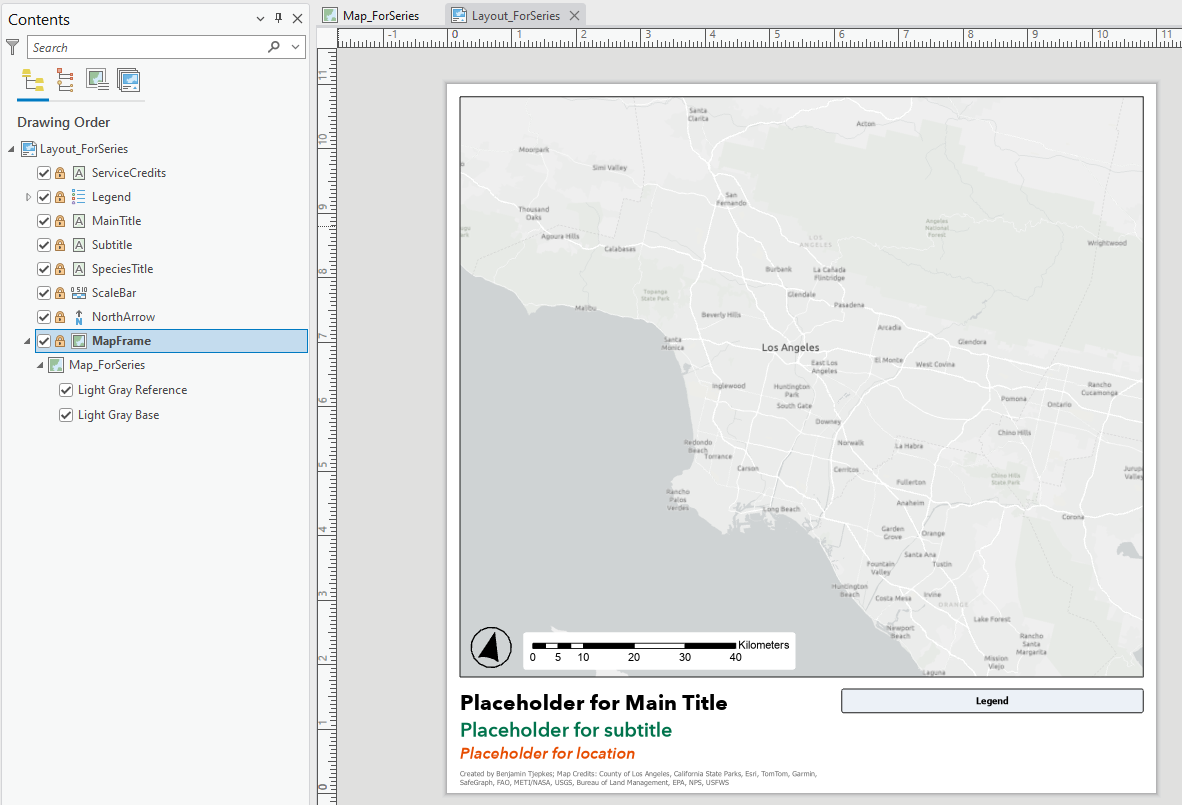

**// Create named variables for map and layout in the template project.**
- Using the names from the above print statement, establush variables for the target map and layout for this workflow.
- Hint: This workflow only has 1 map and 1 layout to reference.

In [21]:
# reference the main map
mainMap = aprxProject.listMaps('Map_ForSeries')[0]

# reference the layout
projectLayout = aprxProject.listLayouts('Layout_ForSeries')[0]

**// Add layers to the main map.**
- Using the `.addLayer` method and referencing the map variable for our project, add layers for the major cities and the bird ellipses.

In [22]:
# add the layer for the top cities FL
mainMap.addLayer(topCitiesFL)

# add the ellipses
mainMap.addLayer(bird_ellipseFL)

**// Print out layers in the main map.**
- By default, since we are adding these layers through arcpy they will be defaultly named. But we can change that so our legends aren't too terrible.
- Iterate over the layers in our project map, then rename any layers as you see fit. Hint: `.name` and `.name.replace`

In [23]:
for lyr in mainMap.listLayers():
    print(lyr.name)
    if "bird_obs_ellipse_Layer" in lyr.name:
        layerName = str(lyr.name)
        lyr.name = lyr.name.replace(layerName, "Observations Standard Ellipse")
        print(f"Layer renamed to: {lyr.name}")
        print("-----------------------")
    if "UrbanAreas_EqualArea_Layer" in lyr.name:
        layerName = str(lyr.name)
        lyr.name = lyr.name.replace(layerName, "Urban Area Boundary")
        print(f"Layer renamed to: {lyr.name}")
        print("-----------------------")

Light Gray Reference
bird_obs_ellipse_Layer
Layer renamed to: Observations Standard Ellipse
-----------------------
UrbanAreas_EqualArea_Layer
Layer renamed to: Urban Area Boundary
-----------------------
Light Gray Base


### Iterative Map Production

**// Iterate over all cities, creating a map for each one ensuring that the proper layers are referenced in each one. (This is a long one.)**
- First establish mp layers for the urban areas and observation ellipses.
- Initialize a blank list to store the map pages.
- Establish a search cursor to run through the NAME of each city in the mp urban areas layer. Hint: `arcpy.da.SearchCursor`
- Iterate over the NAMEs using the search cursor to define a definition query in the urban areas mp layer. Hint: `.definitionQuery`
- Get the extent of each city, then pan the map to that extent. Hint: `.getLayerExtent` and `.panToExtent`
- Since we have individual feature classes for the hotspot clusters, we can make a feature layer and add as an mp layer for these within the iterator.
- Apply the pre-defined symbology for the urban areas and obserservation ellipses. Hint: `arcpy.management.ApplySymbologyFromLayer()`
- Export each layout to the PDF folder we created earlier. Hint: `.exportToPDF()`
- Append this file to our map pages list we initialized earlier. Hint: `.append()`
- Be sure to delete the cluster mp layer in each iterable. Hint: `.removeLayer()`
- Be sure to delete the search cursor and reset the definition queries.

In [24]:
# reference the main map layers
cities_main_Layer = mainMap.listLayers('Urban Area Boundary')[0]
ellipses_main_Layer = mainMap.listLayers('Observations Standard Ellipse')[0]

#This is an empty list called pages. To join all PDF's, there will need to be a list of them
pages = []

## Create a search cursor to assist with creating a PDF map each iteration
cursor = arcpy.da.SearchCursor(in_table = cities_main_Layer,
                               field_names = ['NAME'])

#define a counter variable to track iterations
init = 0

#iterate over each row in the cursor
for record in cursor:
    # test print of record name
    print(record[0])
    
    #retrieve the county name associated with the row
    cityName = record[0]

    # definition query for the service area in main map
    cities_main_Layer.definitionQuery = "NAME = '%s'" % cityName
 
    # list elements
    projectMapFrame = projectLayout.listElements('MAPFRAME_ELEMENT',"MapFrame")[0]

    # get extent of county layer
    lyrextent = projectMapFrame.getLayerExtent(cities_main_Layer)

    # change extent
    projectMapFrame.panToExtent(lyrextent)
    
    # create a clean name string
    cleanname = clean_city_name(cityName)
    
    # subset bird obs ellipse
    ellipses_main_Layer.definitionQuery = "CityName = '%s'" % cleanname
    
    # specify cleanname feature class
    cluster_name = f"Cluster_{cleanname}"
    
    # add sumhex feature layer
    clusterFL = arcpy.management.MakeFeatureLayer(cluster_name)[0]
    
    # add sumhex feature layer to map
    mainMap.addLayer(clusterFL)
    
    arcpy.management.ApplySymbologyFromLayer(cities_main_Layer, "cities_symbology.lyrx")
    
    arcpy.management.ApplySymbologyFromLayer(ellipses_main_Layer, "ellispes_symbology.lyrx")
    
    # set subtitle of map to be the name of the city
    for elm in projectLayout.listElements('TEXT_ELEMENT'):
        if (elm.name == 'MainTitle'):
            elm.text = "Bird Observation Cluster Mapping"
    
    # set subtitle of map to be the name of the city
    for elm in projectLayout.listElements('TEXT_ELEMENT'):
        if (elm.name == 'Subtitle'):
            elm.text = "Project Feeder Watch, 2021-2022"
    
    # set subtitle of map to be the name of the city
    for elm in projectLayout.listElements('TEXT_ELEMENT'):
        if (elm.name == 'SpeciesTitle'):
            elm.text = cityName
    
   # rename the cluster layer now that its in the map
    for lyr in mainMap.listLayers():
        print(lyr.name)
        if lyr.name.startswith("Cluster"):
            layerName = str(lyr.name)
            lyr.name = lyr.name.replace(layerName, "Obs Clusters")
            print(f"Layer found: {layerName}")
            print("-----------------------")

    
    # create path to output pdf with the following naming convention: countyname.pdf
    outputPDF = os.path.join(outputFolder, '%s.pdf' % cleanname)
    print(outputPDF)
    
    #Export the map as a pdf file
    projectLayout.exportToPDF(out_pdf = outputPDF, image_quality = "FASTER") 
    
    #arcpy.mapping.ExportToPDF(mapDocument, outputPDF)
    pages.append(outputPDF)
    
    # remove cluster layer in iteration
    mainMap.removeLayer(clusterFL)
    
    # #This creates individual PDFs for each county, not a combined atlas to test a few pages
    # init += 1
    # if (init >= 2):
    #     break

# delete cursor
del cursor

# clear definition queries
cities_main_Layer.definitionQuery = None
ellipses_main_Layer.definitionQuery = None

Atlanta, GA
Light Gray Reference
Cluster_AtlantaGA_Layer
Layer found: Cluster_AtlantaGA_Layer
-----------------------
Observations Standard Ellipse
Urban Area Boundary
Light Gray Base
D:\GIS2\FinalProject_Full\PDF_Outputs\AtlantaGA.pdf
Baltimore, MD
Light Gray Reference
Cluster_BaltimoreMD_Layer
Layer found: Cluster_BaltimoreMD_Layer
-----------------------
Observations Standard Ellipse
Urban Area Boundary
Light Gray Base
D:\GIS2\FinalProject_Full\PDF_Outputs\BaltimoreMD.pdf
Boston, MA--NH
Light Gray Reference
Cluster_BostonMANH_Layer
Layer found: Cluster_BostonMANH_Layer
-----------------------
Observations Standard Ellipse
Urban Area Boundary
Light Gray Base
D:\GIS2\FinalProject_Full\PDF_Outputs\BostonMANH.pdf
Chicago, IL--IN
Light Gray Reference
Cluster_ChicagoILIN_Layer
Layer found: Cluster_ChicagoILIN_Layer
-----------------------
Observations Standard Ellipse
Urban Area Boundary
Light Gray Base
D:\GIS2\FinalProject_Full\PDF_Outputs\ChicagoILIN.pdf
Dallas--Fort Worth--Arlington, T

**// Assemble all PDFs into an atlas, including a cover page.**
- Now that we have all the PDFs for each layour saved in our PDF folder and stored in our pages list, we can combine these into a map series.
- Create a PDF document using the arcpy.mp module. Hint: `arcpy.mp.PDFDocumentCreate()`
- Iterate over each page in the page list and append them to this newly-created mp PDF document, then save and close this PDF. Hint: `.appendPages()` and `.saveAndClose()`

In [25]:
## define variable to reference Atlas.pdf
atlasPDF = os.path.join(outputFolder, 'MapAtlas.pdf')

## create a pdfDocument in memory (a blank one)
PDFObject = arcpy.mp.PDFDocumentCreate(atlasPDF)

#Add the title page to the beginning
PDFObject.appendPages(os.path.join(BaseDirectory, 'TitlePage.pdf'))

## Sort the pages alphabetically so the Atlas will be in alphabetical order
for page in sorted(pages):
    #append all of the pages together to create one PDF Atlas
    PDFObject.appendPages(page)

#save and close the pdf
PDFObject.saveAndClose()

del PDFObject

#Open the resulting file
os.startfile(atlasPDF)

**// View the resulting PDF map series interactively.**
- Use the `IPython.display` module to establish an iframe pointing to the newly created PDF map series.
- This will only display when the relative path is proper for this file.

In [26]:
from IPython.display import IFrame
IFrame("PDF_Outputs/MapAtlas.pdf", width=600, height=600)

## Appendix

**// Apply some CSS styling to this notebook for improved UX.**
- This is personal preference to define colors, like a green background for all outputs.

In [27]:
%%html
<style>
    h1 {
        color: #0e8050;
        font-weight: bold;
        border-top: solid;
        border-bottom: solid;
        padding: 10px 0;
        }
    h2 {
        font-weight: bold;}
    h3 {
        color: brown;
        }
    .jp-Notebook {
          max-width: 1200px;
          margin: auto;
        }
    .jp-OutputArea-output {
            background: lightgreen;
            }
</style>